# **CIS545 Project**

# **0. Set up libraries and import data**

In [1]:
!pip install pandasql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=c09c00a5f01cc99f1042bc2e60347326c476dd52fb1c49d22898a746188aae23
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql


In [2]:
import json
import glob
import pandas as pd
import pandasql as ps #SQL on Pandas Dataframe
import numpy as np
import sqlite3
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split

**Step 1**:

Read csv files.

**Note**: import all the Kaggle files of the European Soccer Database to "/content/".


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
! mkdir ~/.kaggle

In [8]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [9]:
!kaggle datasets download -d hugomathien/soccer

 76% 25.0M/32.7M [00:00<00:00, 135MB/s] 
100% 32.7M/32.7M [00:00<00:00, 144MB/s]


In [10]:
!unzip /content/soccer.zip

Archive:  /content/soccer.zip
  inflating: database.sqlite         


In [11]:
con = sqlite3.connect("database.sqlite")
# country_df = pd.read_sql_query("SELECT * from country", con)
# league_df = pd.read_sql_query("SELECT * from league", con)
# match_df = pd.read_sql_query("SELECT * from match", con)
player_df = pd.read_sql_query("SELECT * from player", con)
player_attributes_df = pd.read_sql_query("SELECT * from player_attributes", con)
team_df = pd.read_sql_query("SELECT * from team", con)
team_attributes_df = pd.read_sql_query("SELECT * from team_attributes", con)

con.close()

To Do List: 
* Investigate data import  
* Link data between files
  *  Get team linked to match to player to get player team by year
* remove columns from tables that we do not want or need
* convert column data type to int/float
*   Determine list of players who appear in the first and last years of the data, as these players will be our primary cohort for testing?
* https://www.kaggle.com/code/manasaudupa/european-soccer-data-analysis-using-sql/notebook


# **1. Clean & Stage the Data**

To work with the data, we would require to clean the data i.e drop null values, remove columns that are not needed, drop duplicates, etc.

## **1.1 Drop null values**

In [12]:
player_cleaned_df = player_df.dropna()
player_attributes_cleaned_df = player_attributes_df.dropna()
team_cleaned_df = team_df.dropna()
team_attributes_cleaned_df = team_attributes_df.dropna()

## **1.2 Drop Duplicates**

In [13]:
player_cleaned_df = player_cleaned_df.drop_duplicates()
player_attributes_cleaned_df = player_attributes_cleaned_df.drop_duplicates()
team_cleaned_df = team_cleaned_df.drop_duplicates()
team_attributes_cleaned_df = team_attributes_cleaned_df.drop_duplicates()
team_attributes_cleaned_df.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
7,8,77,8485,2014-09-19 00:00:00,58,Balanced,64.0,Normal,62,Mixed,...,57,Normal,Organised,41,Medium,42,Press,60,Normal,Cover
8,9,77,8485,2015-09-10 00:00:00,59,Balanced,64.0,Normal,53,Mixed,...,63,Normal,Free Form,49,Medium,45,Press,63,Normal,Cover
13,14,614,8576,2014-09-19 00:00:00,59,Balanced,57.0,Normal,52,Mixed,...,52,Normal,Organised,38,Medium,47,Press,53,Normal,Cover


Let's check the datatypes for our player table




In [14]:
player_attributes_cleaned_df.dtypes

id                       int64
player_fifa_api_id       int64
player_api_id            int64
date                    object
overall_rating         float64
potential              float64
preferred_foot          object
attacking_work_rate     object
defensive_work_rate     object
crossing               float64
finishing              float64
heading_accuracy       float64
short_passing          float64
volleys                float64
dribbling              float64
curve                  float64
free_kick_accuracy     float64
long_passing           float64
ball_control           float64
acceleration           float64
sprint_speed           float64
agility                float64
reactions              float64
balance                float64
shot_power             float64
jumping                float64
stamina                float64
strength               float64
long_shots             float64
aggression             float64
interceptions          float64
positioning            float64
vision  

In [15]:
player_cleaned_df.dtypes

id                      int64
player_api_id           int64
player_name            object
player_fifa_api_id      int64
birthday               object
height                float64
weight                  int64
dtype: object

## **1.3 Join the tables**

1.   Join player attributes and player table data using player_api_id
2.   Remove unwanted columns and rename the columns after joining for cleaner table data





In [16]:
players_and_skills_df = player_attributes_cleaned_df.merge(player_cleaned_df, on="player_fifa_api_id")
players_and_skills_df = players_and_skills_df.drop(columns=['player_api_id_x', 'id_y', 'preferred_foot'])
players_and_skills_df = players_and_skills_df.rename(columns={"player_api_id_y": "player_api_id", "id_x" : "id"})
players_and_skills_df.head()

,id,player_fifa_api_id,date,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_api_id,player_name,birthday,height,weight
0,1,218353,2016-02-18 00:00:00,67.0,71.0,medium,medium,49.0,44.0,71.0,...,6.0,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
1,2,218353,2015-11-19 00:00:00,67.0,71.0,medium,medium,49.0,44.0,71.0,...,6.0,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
2,3,218353,2015-09-21 00:00:00,62.0,66.0,medium,medium,49.0,44.0,71.0,...,6.0,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
3,4,218353,2015-03-20 00:00:00,61.0,65.0,medium,medium,48.0,43.0,70.0,...,5.0,10.0,9.0,7.0,7.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
4,5,218353,2007-02-22 00:00:00,61.0,65.0,medium,medium,48.0,43.0,70.0,...,5.0,10.0,9.0,7.0,7.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187


## **1.4 Calculate the age of the players**

In [17]:
players_and_skills_df['age'] = players_and_skills_df.apply(lambda x: pd.to_datetime(x['date']).year - pd.to_datetime(x['birthday']).year, axis=1)
players_and_skills_df.head()

,id,player_fifa_api_id,date,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_api_id,player_name,birthday,height,weight,age
0,1,218353,2016-02-18 00:00:00,67.0,71.0,medium,medium,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,24
1,2,218353,2015-11-19 00:00:00,67.0,71.0,medium,medium,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,23
2,3,218353,2015-09-21 00:00:00,62.0,66.0,medium,medium,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,23
3,4,218353,2015-03-20 00:00:00,61.0,65.0,medium,medium,48.0,43.0,70.0,...,10.0,9.0,7.0,7.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,23
4,5,218353,2007-02-22 00:00:00,61.0,65.0,medium,medium,48.0,43.0,70.0,...,10.0,9.0,7.0,7.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,15


We can also observe that our table has some categorical values that we will need to convert to integer/float to run our ML model. 

In [18]:
def assign(x):
  if x == "low":
    x = 3
    return x 
  elif x == "medium":
    x = 6
    return x
  elif x == "high":
    x = 9
    return x
  else:
    return 0

players_and_skills_df['defensive_work_rate'] = players_and_skills_df['defensive_work_rate'].apply(lambda x: assign(x))
players_and_skills_df['attacking_work_rate'] = players_and_skills_df['attacking_work_rate'].apply(lambda x: assign(x))
players_and_skills_df.head()

,id,player_fifa_api_id,date,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_api_id,player_name,birthday,height,weight,age
0,1,218353,2016-02-18 00:00:00,67.0,71.0,6,6,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,24
1,2,218353,2015-11-19 00:00:00,67.0,71.0,6,6,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,23
2,3,218353,2015-09-21 00:00:00,62.0,66.0,6,6,49.0,44.0,71.0,...,11.0,10.0,8.0,8.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,23
3,4,218353,2015-03-20 00:00:00,61.0,65.0,6,6,48.0,43.0,70.0,...,10.0,9.0,7.0,7.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,23
4,5,218353,2007-02-22 00:00:00,61.0,65.0,6,6,48.0,43.0,70.0,...,10.0,9.0,7.0,7.0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187,15


## **1.5 Visualize data**

Let's visualize what our distribution of players looks like by year:

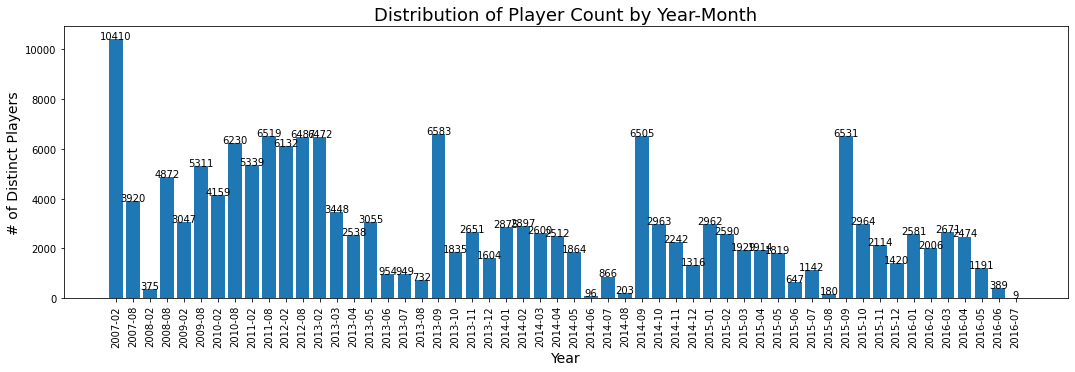

In [19]:
player_year_query = """
WITH player_years AS (
    SELECT player_fifa_api_id,
           (strftime('%Y-%m',date)) AS year_month
    FROM players_and_skills_df
    
    GROUP BY player_fifa_api_id, (strftime('%Y-%m',date))
)

SELECT year_month, COUNT(player_fifa_api_id) AS player_count
FROM player_years
GROUP BY year_month
"""
sql_player_year_df = ps.sqldf(player_year_query, locals())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

plt.subplots(figsize=(18,5))
plt.bar(sql_player_year_df['year_month'], sql_player_year_df['player_count'])
plt.title("Distribution of Player Count by Year-Month",fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('# of Distinct Players', fontsize=14)
plt.xticks(rotation=90)
addlabels(sql_player_year_df['year_month'], sql_player_year_df['player_count'])
plt.show()

#https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

We will limit our data to just full soccer seasons, which begin in August. Therefore we can remove the data in 2007-02. 

In [20]:
#Remove the players that get added in 2007-02
players_and_skills_df = players_and_skills_df[players_and_skills_df['date'] >= '2007-08-01']


# **2. Analysis**

## **2.1 Find correlation between Player skills**


<ipython-input-21-3ff953532c03>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(player_skills_heatmap.corr(), dtype=np.bool)


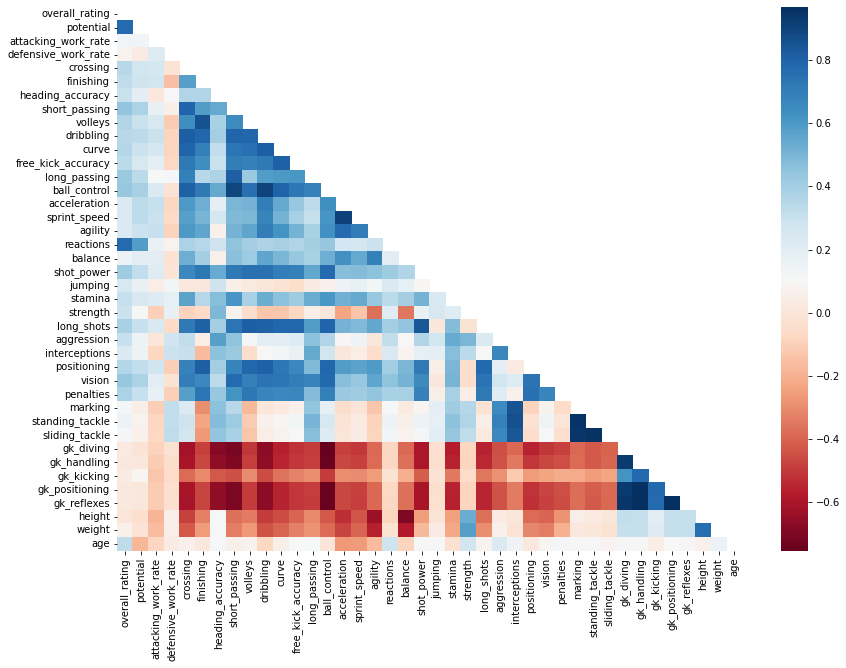

In [21]:
player_skills_heatmap = players_and_skills_df.drop(columns=['id', 'player_fifa_api_id', 'player_api_id'])

mask = np.zeros_like(player_skills_heatmap.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(14, 10))
sns.heatmap(player_skills_heatmap.corr(), mask=mask, cmap="RdBu")

## **2.2 Understanding key aspects of player data**



We want to understand how many years players we have in the data

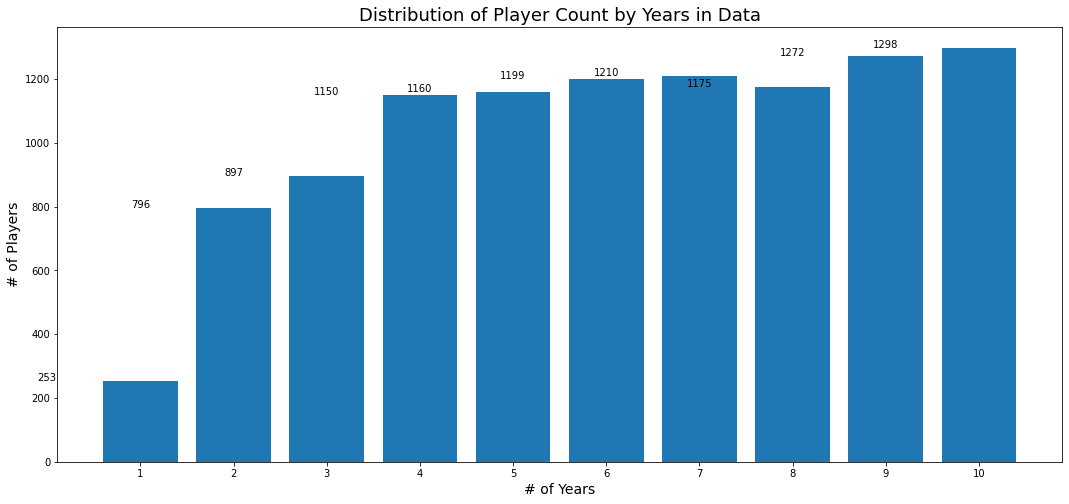

In [22]:
player_avg_year_query = """
WITH player_years AS (
    SELECT player_fifa_api_id,
           (strftime('%Y',date)) AS year
    FROM players_and_skills_df
    GROUP BY player_fifa_api_id, (strftime('%Y',date))
),
player_avg_years AS (
  SELECT player_fifa_api_id,
          COUNT(DISTINCT year) AS data_years
  FROM player_years
  GROUP BY player_fifa_api_id 
)

SELECT data_years, COUNT(player_fifa_api_id) AS player_count
FROM player_avg_years
GROUP BY data_years
"""
sql_player_avg_year_df = ps.sqldf(player_avg_year_query, locals())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

plt.subplots(figsize=(18,8))
plt.bar(sql_player_avg_year_df['data_years'], sql_player_avg_year_df['player_count'])
plt.title("Distribution of Player Count by Years in Data",fontsize=18)
plt.xlabel('# of Years', fontsize=14)
plt.ylabel('# of Players', fontsize=14)
plt.xticks(np.arange(1,len(sql_player_avg_year_df['data_years'])+1, step=1))
addlabels(sql_player_avg_year_df['data_years'], sql_player_avg_year_df['player_count'])
plt.show()

It appears that we have over 2000 players with a full 10 years in the data. With this cohort of players with the most data, we can see when they "peaked" by finding the last date they had their highest 'overall_rating' score. 

For a given player, we want to answer the following question: 
*   Over the next period/season, will the player's overall rating be in RISE or DECLINE phase?

We'll develop machine learning models to answer this question. Our models will be a "screening" method for scouters 


In [23]:
#First limit to players with 10 years of results
player_yrs_10_query = """
WITH player_years AS (
    SELECT player_fifa_api_id,
           (strftime('%Y',date)) AS year
    FROM players_and_skills_df
    GROUP BY player_fifa_api_id, (strftime('%Y',date))
),
player_avg_years AS (
  SELECT player_fifa_api_id,
          COUNT(DISTINCT year) AS data_years
  FROM player_years
  GROUP BY player_fifa_api_id 
)

SELECT player_fifa_api_id
FROM player_avg_years
WHERE data_years >= 10
GROUP BY player_fifa_api_id
"""
sql_player_yrs_10_df = ps.sqldf(player_yrs_10_query, locals())

In [24]:
#Join table to master table and limit data to just these players
player_ratings_limited_query = """
WITH player_rating_age AS (
    SELECT player_fifa_api_id, overall_rating, age
    FROM players_and_skills_df
    GROUP BY player_fifa_api_id, overall_rating, age
)

SELECT X.player_fifa_api_id, X.overall_rating, X.age
FROM player_rating_age X
    JOIN sql_player_yrs_10_df Y on X.player_fifa_api_id = Y.player_fifa_api_id
GROUP BY X.player_fifa_api_id, X.overall_rating, X.age
"""
sql_player_ratings_limited_df = ps.sqldf(player_ratings_limited_query, locals())


In [25]:

#Determine the max overall rating for these players. If multiple, then select latest date
player_ratings_peak_query = """
WITH player_rating_max AS (
    SELECT player_fifa_api_id, max(overall_rating) AS max_rating
    FROM sql_player_ratings_limited_df X
    GROUP BY player_fifa_api_id
),
player_rating_age_max AS (
    SELECT X.player_fifa_api_id, MAX(X.age) as max_age
    FROM sql_player_ratings_limited_df X
      JOIN player_rating_max Y on X.player_fifa_api_id = Y.player_fifa_api_id AND X.overall_rating = Y.max_rating
    GROUP BY X.player_fifa_api_id
)

SELECT X.player_fifa_api_id, 
       X.overall_rating, 
       X.age,
       CASE
          WHEN X.age < Y.max_age THEN 'RISE'
          WHEN X.age = Y.max_age AND X.overall_rating < Z.max_rating THEN 'RISE'
          WHEN X.age = Y.max_age AND X.overall_rating = Z.max_rating THEN 'PEAK'
          ELSE 'DECLINE'
      END AS peak_flg
FROM sql_player_ratings_limited_df X
    LEFT JOIN player_rating_age_max Y 
      on X.player_fifa_api_id = Y.player_fifa_api_id
    LEFT JOIN player_rating_max Z 
      on X.player_fifa_api_id = Z.player_fifa_api_id 
GROUP BY X.player_fifa_api_id, 
       X.overall_rating, 
       X.age,
       CASE
          WHEN X.age < Y.max_age THEN 'RISE'
          WHEN X.age = Y.max_age AND X.overall_rating < Z.max_rating THEN 'RISE'
          WHEN X.age = Y.max_age AND X.overall_rating = Z.max_rating THEN 'PEAK'
          ELSE 'DECLINE'
      END
"""
sql_player_ratings_peak_df = ps.sqldf(player_ratings_peak_query, locals())

Doing a check to see what the data looks like to ensure that we are properly capturing the rise, peak, and decline

In [26]:
sql_player_ratings_peak_df[(sql_player_ratings_peak_df['player_fifa_api_id'] == 684)].sort_values(by = 'age').head(100)
#sql_player_ratings_peak_df[(sql_player_ratings_peak_df['age'] == 18) & (sql_player_ratings_peak_df['peak_flg'] == 'PEAK')] #684 11983 158718 189484

,player_fifa_api_id,overall_rating,age,peak_flg
100,684,77.0,35,RISE
97,684,75.0,36,RISE
101,684,77.0,37,RISE
104,684,79.0,37,RISE
106,684,80.0,38,RISE
107,684,80.0,39,RISE
109,684,81.0,39,PEAK
108,684,80.0,40,DECLINE
103,684,78.0,41,DECLINE
105,684,79.0,41,DECLINE


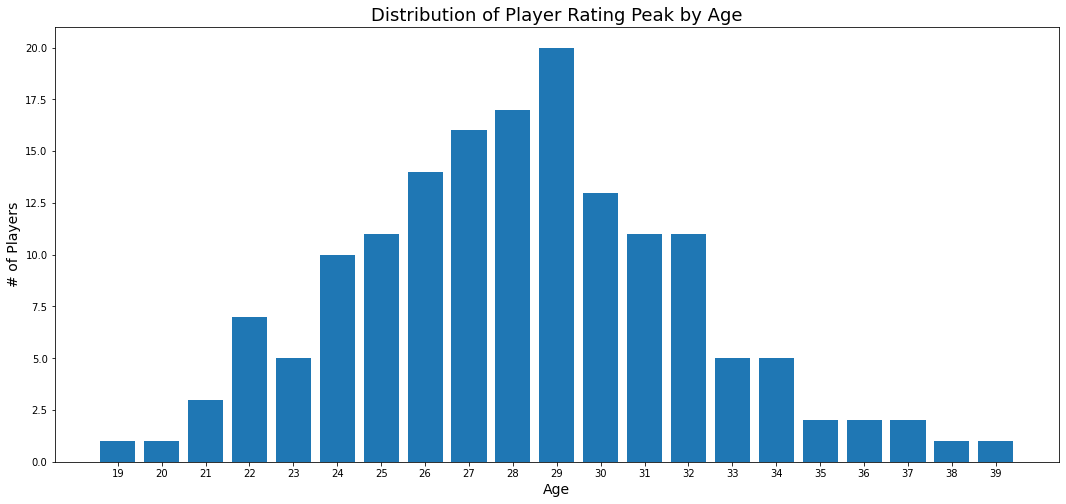

In [27]:
#Plot the distribution of the average age they reach peak.
player_peak_query = """
SELECT COUNT(player_fifa_api_id) AS player_count, 
       overall_rating, 
       age
FROM sql_player_ratings_peak_df  
WHERE peak_flg = 'PEAK'
GROUP BY overall_rating, 
       age
"""
players_peak_df = ps.sqldf(player_peak_query, locals())

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')

plt.subplots(figsize=(18,8))
plt.bar(players_peak_df['age'], players_peak_df['player_count'])
plt.title("Distribution of Player Rating Peak by Age",fontsize=18)
plt.xlabel('Age', fontsize=14)
plt.ylabel('# of Players', fontsize=14)
plt.xticks(np.arange(min(players_peak_df['age']),max(players_peak_df['age'])+1, step=1))
plt.show()

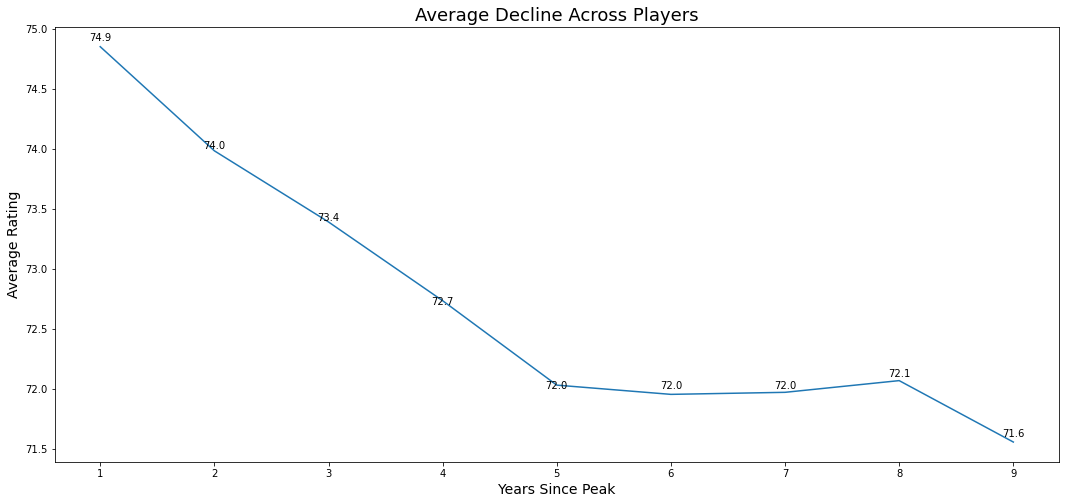

In [28]:
#From peak, plot the average trajectory of score decline 
#For consistency, take the highest number in each year, so we can compare declines accurately
player_decline_query = """
WITH decline_years AS (
  SELECT player_fifa_api_id,
        overall_rating, 
        age
  FROM sql_player_ratings_peak_df
  WHERE peak_flg = 'DECLINE'
  GROUP BY player_fifa_api_id,
        overall_rating, 
        age
)

SELECT X.player_fifa_api_id,
      MAX(X.overall_rating) AS rating_year,
      X.age
  FROM players_and_skills_df X
      JOIN decline_years Y ON X.player_fifa_api_id = Y.player_fifa_api_id AND X.overall_rating = Y.overall_rating AND X.age = Y.age
  GROUP BY X.player_fifa_api_id,
      X.age
"""
player_decline_df = ps.sqldf(player_decline_query, locals())

#Find the average score by years after peak 
player_decline_df['rank'] = player_decline_df.groupby(by = 'player_fifa_api_id')['age'].rank(method = 'first')
player_avg_decline_df = player_decline_df.groupby(by = 'rank')['rating_year'].mean().reset_index(name = 'avg_rating')

#Plot the resulting line
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i+1, y[i], y[i], ha = 'center')

plt.subplots(figsize=(18,8))
plt.plot(player_avg_decline_df['rank'], player_avg_decline_df['avg_rating'])
plt.title("Average Decline Across Players",fontsize=18)
plt.xlabel('Years Since Peak', fontsize=14)
plt.ylabel('Average Rating', fontsize=14)
plt.xticks(np.arange(min(player_avg_decline_df['rank']),max(player_avg_decline_df['rank'])+1, step=1))
addlabels(player_avg_decline_df['rank'], round(player_avg_decline_df['avg_rating'],1))
plt.show()


## **2.3 Finalizing our dataset for classification analyses**

After performing the above analyses, we determined that we will need at least three years of data to have a baseline understanding of a players rise, peak, and decline. We will limit our dataset to players with three years and then proceed to add a column with the three classifications of a players trajectory

We understand there a limitations to this approach, since we are no viewing a players full rise and decline. However, we believe that defining this trajectory will be sufficiently useful for classification and testing our predictions. 

For the below additional columns, we will limit to 'Rise' and 'Decline' in order make the column entries binary. We understand a player's peak to be their final rating at 'Rise'.  

In [29]:
#First limit to players with 3+ years of results
player_yrs_3_query = """
WITH player_years AS (
    SELECT player_fifa_api_id,
           (strftime('%Y',date)) AS year
    FROM players_and_skills_df
    GROUP BY player_fifa_api_id, (strftime('%Y',date))
),
player_avg_years AS (
  SELECT player_fifa_api_id,
          COUNT(DISTINCT year) AS data_years
  FROM player_years
  GROUP BY player_fifa_api_id 
)

SELECT player_fifa_api_id
FROM player_avg_years
WHERE data_years >= 3
GROUP BY player_fifa_api_id
"""
player_yrs_3_df = ps.sqldf(player_yrs_3_query, locals())

In [30]:
#Join table to master table and limit data to just these players
player_ratings_3_query = """
WITH player_rating_age AS (
    SELECT player_fifa_api_id, overall_rating, age
    FROM players_and_skills_df
    GROUP BY player_fifa_api_id, overall_rating, age
)

SELECT X.player_fifa_api_id, X.overall_rating, X.age
FROM player_rating_age X
    JOIN player_yrs_3_df Y on X.player_fifa_api_id = Y.player_fifa_api_id
GROUP BY X.player_fifa_api_id, X.overall_rating, X.age
"""
sql_player_ratings_3_df = ps.sqldf(player_ratings_3_query, locals())

In [31]:
#Determine the max overall rating for these players. If multiple, then select latest date
player_ratings_peak_3_query = """
WITH player_rating_max AS (
    SELECT player_fifa_api_id, max(overall_rating) AS max_rating
    FROM sql_player_ratings_3_df X
    GROUP BY player_fifa_api_id
),
player_rating_age_max AS (
    SELECT X.player_fifa_api_id, MAX(X.age) as max_age
    FROM sql_player_ratings_3_df X
      JOIN player_rating_max Y on X.player_fifa_api_id = Y.player_fifa_api_id AND X.overall_rating = Y.max_rating
    GROUP BY X.player_fifa_api_id
)

SELECT X.player_fifa_api_id, 
       X.overall_rating, 
       X.age,
       CASE
          WHEN X.age < Y.max_age THEN 'RISE'
          WHEN X.age = Y.max_age AND X.overall_rating < Z.max_rating THEN 'RISE'
          WHEN X.age = Y.max_age AND X.overall_rating = Z.max_rating THEN 'RISE'
          ELSE 'DECLINE'
      END AS peak_flg
FROM sql_player_ratings_3_df X
    LEFT JOIN player_rating_age_max Y 
      on X.player_fifa_api_id = Y.player_fifa_api_id
    LEFT JOIN player_rating_max Z 
      on X.player_fifa_api_id = Z.player_fifa_api_id 
GROUP BY X.player_fifa_api_id, 
       X.overall_rating, 
       X.age,
       CASE
          WHEN X.age < Y.max_age THEN 'RISE'
          WHEN X.age = Y.max_age AND X.overall_rating < Z.max_rating THEN 'RISE'
          WHEN X.age = Y.max_age AND X.overall_rating = Z.max_rating THEN 'RISE'
          ELSE 'DECLINE'
      END
"""
sql_player_ratings_peak_3_df = ps.sqldf(player_ratings_peak_3_query, locals())

In [33]:
#Merge datasets to make a master dataset for usage below 
TEMP_players_and_skills_df = players_and_skills_df.merge(sql_player_ratings_peak_3_df, on= ["player_fifa_api_id", "overall_rating", "age"])
TEMP_players_and_skills_df['rank'] = TEMP_players_and_skills_df.groupby(by = 'player_fifa_api_id')['date'].rank(method = 'first')

#Merge again with next row to get the future peak flag
MASTER_players_and_skills_query = """
SELECT X.*,
      Y.peak_flg AS peak_flg_2

FROM TEMP_players_and_skills_df X
  LEFT JOIN TEMP_players_and_skills_df Y ON X.player_fifa_api_id = Y.player_fifa_api_id AND X.rank = Y.rank - 1
"""
MASTER_players_and_skills_df = ps.sqldf(MASTER_players_and_skills_query, locals())

MASTER_players_and_skills_df = MASTER_players_and_skills_df.drop(columns = ['rank'])

In [34]:
MASTER_players_and_skills_df[(MASTER_players_and_skills_df['player_fifa_api_id'] == 11983)].sort_values(by = ['player_fifa_api_id','date']).tail(10)

,id,player_fifa_api_id,date,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,gk_positioning,gk_reflexes,player_api_id,player_name,birthday,height,weight,age,peak_flg,peak_flg_2
20284,22674,11983,2012-08-31 00:00:00,80.0,80.0,6,6,17.0,18.0,18.0,...,83.0,80.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,41,DECLINE,DECLINE
20283,22673,11983,2013-02-15 00:00:00,80.0,80.0,6,6,17.0,18.0,18.0,...,83.0,80.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,42,DECLINE,DECLINE
20282,22672,11983,2013-04-26 00:00:00,80.0,80.0,6,6,17.0,18.0,18.0,...,83.0,80.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,42,DECLINE,DECLINE
20281,22671,11983,2013-09-20 00:00:00,79.0,79.0,6,6,25.0,25.0,25.0,...,82.0,79.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,42,DECLINE,DECLINE
20280,22670,11983,2013-10-11 00:00:00,79.0,79.0,6,6,25.0,25.0,25.0,...,82.0,79.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,42,DECLINE,DECLINE
20279,22669,11983,2014-01-10 00:00:00,79.0,79.0,6,6,25.0,25.0,25.0,...,82.0,79.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,43,DECLINE,DECLINE
20278,22668,11983,2014-01-24 00:00:00,79.0,79.0,6,6,25.0,25.0,25.0,...,82.0,78.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,43,DECLINE,DECLINE
20277,22667,11983,2014-04-25 00:00:00,78.0,78.0,6,6,25.0,25.0,25.0,...,80.0,77.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,43,DECLINE,DECLINE
20276,22666,11983,2014-09-18 00:00:00,78.0,78.0,6,6,25.0,25.0,25.0,...,82.0,76.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,43,DECLINE,DECLINE
20275,22665,11983,2015-03-06 00:00:00,77.0,77.0,6,6,25.0,25.0,25.0,...,82.0,74.0,30380,Brad Friedel,1971-05-18 00:00:00,187.96,203,44,DECLINE,None


In [35]:
MASTER_players_and_skills_df.describe()

,id,player_fifa_api_id,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,...,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes,player_api_id,height,weight,age
count,165091.00000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,...,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000,165091.000000
mean,91925.42548,165175.708209,69.196673,73.703418,6.468196,6.029311,55.772035,50.365756,57.685392,63.070773,...,48.317195,14.789359,15.947756,19.762513,16.022903,16.333561,127922.836260,181.884515,168.911933,26.131007
std,53020.56658,52541.102142,6.700451,6.454431,1.764604,1.749202,17.241680,19.066173,16.519574,14.053400,...,21.679517,16.986953,15.991221,20.737289,16.236961,17.350154,124048.816181,6.406929,15.106036,4.417982
min,6.00000,2.000000,33.000000,39.000000,0.000000,0.000000,1.000000,1.000000,1.000000,3.000000,...,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2625.000000,157.480000,117.000000,15.000000
25%,46071.50000,155862.000000,65.000000,69.000000,6.000000,6.000000,46.000000,35.000000,50.000000,58.000000,...,25.000000,7.000000,8.000000,8.000000,8.000000,8.000000,34479.000000,177.800000,159.000000,23.000000
50%,91824.00000,183256.000000,69.000000,74.000000,6.000000,6.000000,60.000000,54.000000,60.000000,66.000000,...,54.000000,10.000000,11.000000,11.000000,11.000000,11.000000,74744.000000,182.880000,168.000000,26.000000
75%,137714.50000,198951.000000,74.000000,78.000000,6.000000,6.000000,68.000000,66.000000,69.000000,72.000000,...,67.000000,13.000000,15.000000,15.000000,15.000000,15.000000,185618.000000,185.420000,179.000000,29.000000
max,183977.00000,230592.000000,94.000000,97.000000,9.000000,9.000000,95.000000,97.000000,95.000000,97.000000,...,95.000000,94.000000,92.000000,97.000000,96.000000,96.000000,722766.000000,208.280000,243.000000,44.000000


## **2.4 Selecting a subset of players to further analyze**
We'll select a group of players and then visualize the evolution of their overall rating over their last 10 periods of data (last 10 data entries for each player).

After we build our classification models, we'll use our best model to make the following prediction for each player: **Will a player's overall rating be in DECLINE phase over the next period?** For some of them who are in their **RISE** phase, the question is even more interesting.

In [36]:
#Query to get historical data
historical_data_query = """
SELECT player_name, overall_rating, date
FROM MASTER_players_and_skills_df
WHERE player_name IN ('Lionel Messi', 'Santi Cazorla', 'Sergio Garcia','Gerard Pique', 'Cristiano Ronaldo', 'Edinson Cavani', 'Eden Hazard', 'Virgil van Dijk', 'Andres Iniesta')
"""
historical_rating_df = ps.sqldf(historical_data_query, locals())
historical_rating_df

,player_name,overall_rating,date
0,Andres Iniesta,88.0,2015-10-16 00:00:00
1,Andres Iniesta,88.0,2015-09-21 00:00:00
2,Andres Iniesta,89.0,2014-11-07 00:00:00
3,Andres Iniesta,89.0,2014-10-17 00:00:00
4,Andres Iniesta,89.0,2014-09-18 00:00:00
...,...,...,...
223,Virgil van Dijk,71.0,2013-03-28 00:00:00
224,Virgil van Dijk,71.0,2013-03-22 00:00:00
225,Virgil van Dijk,71.0,2012-08-31 00:00:00
226,Virgil van Dijk,68.0,2012-02-22 00:00:00


In [80]:
#Assign row numbers (periods of data) to each player and keep only the last 10 periods
historical_rating_df.loc[:, ('period_backwards')] = historical_rating_df.groupby('player_name')['date'].rank(method='first', ascending=False)
historical_rating_df = historical_rating_df[historical_rating_df['period_backwards']<=10]
historical_rating_df.loc[:, ('period')] = historical_rating_df['period_backwards'].apply(lambda x: 11 - x)
historical_rating_df.drop(columns=['period_backwards'], inplace=True)

historical_rating_df.head(30)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


,player_name,overall_rating,date,period
0,Andres Iniesta,88.0,2015-10-16 00:00:00,10.0
1,Andres Iniesta,88.0,2015-09-21 00:00:00,9.0
2,Andres Iniesta,89.0,2014-11-07 00:00:00,8.0
3,Andres Iniesta,89.0,2014-10-17 00:00:00,7.0
4,Andres Iniesta,89.0,2014-09-18 00:00:00,6.0
5,Andres Iniesta,89.0,2014-05-16 00:00:00,5.0
6,Andres Iniesta,89.0,2013-12-20 00:00:00,4.0
7,Andres Iniesta,89.0,2013-09-20 00:00:00,3.0
8,Andres Iniesta,90.0,2013-06-07 00:00:00,2.0
9,Andres Iniesta,90.0,2013-05-24 00:00:00,1.0


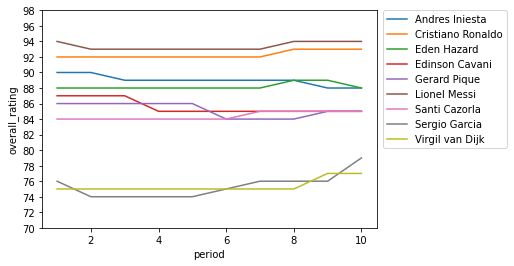

In [38]:
players_plot = sns.lineplot(data=historical_rating_df, x="period", y="overall_rating", hue="player_name")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.yticks([x for x in range(70,100) if x%2 == 0]);

# **3. Classification Models**

## **3.1 Modeling**

We're going to create two dataframes to separate goalkeeping skills from player skills. 

In [39]:
player_skills = MASTER_players_and_skills_df.drop(columns=['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'])
goalkeeper_skills = MASTER_players_and_skills_df[['gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes']]

After separating player's and goalkeeper's skills, we're going to separate our final player dataset that we will test on after training or models. 

The rows we're going to separate have `peak_flg_2` column as 'None', which basically means that there is no data for that particular player after this point in time. 

We will resolve this issue via our ML models by training our it on historical values and tehn predicting their future performance.   

In [40]:
final_player_df = player_skills[player_skills['peak_flg_2'].isnull()]
final_player_df 

,id,player_fifa_api_id,date,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,standing_tackle,sliding_tackle,player_api_id,player_name,birthday,height,weight,age,peak_flg,peak_flg_2
0,6,189615,2016-04-21 00:00:00,74.0,76.0,9,6,80.0,53.0,58.0,...,75.0,78.0,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,27,RISE,None
32,39,186170,2016-01-07 00:00:00,65.0,67.0,6,6,64.0,58.0,60.0,...,22.0,24.0,162549,Aaron Doran,1991-05-13 00:00:00,170.18,163,25,DECLINE,None
57,65,140161,2016-04-21 00:00:00,69.0,69.0,6,6,57.0,21.0,68.0,...,71.0,68.0,30572,Aaron Galindo,1982-05-08 00:00:00,182.88,198,34,DECLINE,None
79,88,17725,2015-12-24 00:00:00,70.0,70.0,6,6,46.0,34.0,73.0,...,73.0,71.0,23780,Aaron Hughes,1979-11-08 00:00:00,182.88,154,36,DECLINE,None
103,113,158138,2016-04-28 00:00:00,77.0,77.0,6,6,77.0,72.0,64.0,...,34.0,35.0,27316,Aaron Hunt,1986-09-04 00:00:00,182.88,161,30,DECLINE,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165028,183896,195840,2016-01-21 00:00:00,64.0,64.0,6,6,65.0,60.0,42.0,...,26.0,24.0,192132,Zouhaier Dhaouadhi,1988-01-01 00:00:00,180.34,159,28,RISE,None
165035,183904,205705,2016-02-04 00:00:00,75.0,76.0,6,6,57.0,40.0,73.0,...,79.0,71.0,282473,Zouhair Feddal,1989-01-01 00:00:00,190.50,172,27,RISE,None
165055,183925,2488,2015-03-06 00:00:00,73.0,73.0,3,6,42.0,27.0,74.0,...,77.0,72.0,26357,Zoumana Camara,1979-04-03 00:00:00,182.88,168,36,DECLINE,None
165067,183938,164680,2014-09-18 00:00:00,63.0,67.0,9,6,65.0,44.0,59.0,...,61.0,61.0,111182,Zsolt Laczko,1986-12-18 00:00:00,182.88,176,28,DECLINE,None


Let's separate all rows that have `peak_flg_2` as None value. This is because `peak_flg_2` column predicts rise/decline based on next(future) datapoint's attribute and since these rows are last in the dataset, they can't be predicted on. 

We will be predicting the future performace on those rows once our model is created. 



In [41]:
player_skills = player_skills[(player_skills['peak_flg_2'] == 'RISE') | (player_skills['peak_flg_2'] == 'DECLINE')]
player_skills

,id,player_fifa_api_id,date,overall_rating,potential,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,...,standing_tackle,sliding_tackle,player_api_id,player_name,birthday,height,weight,age,peak_flg,peak_flg_2
1,7,189615,2016-04-07 00:00:00,74.0,76.0,9,6,80.0,53.0,58.0,...,75.0,78.0,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,27,RISE,RISE
2,8,189615,2016-01-07 00:00:00,73.0,75.0,9,6,79.0,52.0,57.0,...,75.0,78.0,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,27,RISE,RISE
3,9,189615,2015-12-24 00:00:00,73.0,75.0,9,6,79.0,51.0,57.0,...,75.0,78.0,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,26,RISE,RISE
4,10,189615,2015-12-17 00:00:00,73.0,75.0,9,6,79.0,51.0,57.0,...,75.0,78.0,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,26,RISE,RISE
5,11,189615,2015-10-16 00:00:00,73.0,77.0,9,6,79.0,51.0,57.0,...,75.0,78.0,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146,26,RISE,RISE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165086,183973,102359,2010-08-30 00:00:00,83.0,85.0,6,3,84.0,78.0,59.0,...,31.0,30.0,39902,Zvjezdan Misimovic,1982-06-05 00:00:00,180.34,176,28,RISE,DECLINE
165087,183974,102359,2009-08-30 00:00:00,83.0,85.0,6,3,84.0,77.0,59.0,...,31.0,30.0,39902,Zvjezdan Misimovic,1982-06-05 00:00:00,180.34,176,27,RISE,RISE
165088,183975,102359,2009-02-22 00:00:00,78.0,80.0,6,3,74.0,76.0,53.0,...,31.0,30.0,39902,Zvjezdan Misimovic,1982-06-05 00:00:00,180.34,176,27,RISE,RISE
165089,183976,102359,2008-08-30 00:00:00,77.0,80.0,6,3,74.0,71.0,53.0,...,31.0,30.0,39902,Zvjezdan Misimovic,1982-06-05 00:00:00,180.34,176,26,RISE,RISE


### 3.1.1 Creating the classification labels

To run machine learning models all our column values need to be integer or float. Since our `peak flag` column is a categorical value, we will change it to a binary value. If the `peak flag` is `RISE`, we will change it to 1 and if it is `DECLINE`, we will change it to 0. 

In [42]:
player_skills['peak_boolean'] = player_skills['peak_flg_2'].apply(lambda x: 0 if x == 'DECLINE' else 1)

Since we need to start classifying data into features and labels to train and test, we create two dataframes for the same.

In [43]:
player_skills_features = player_skills.drop(columns=['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential', 'player_name', 'date', 'birthday', 'height', 'weight', 'peak_flg', 'peak_flg_2', 'peak_boolean'])
player_rating_label = player_skills['peak_boolean']
player_rating_label = pd.Series(player_rating_label)

In [44]:
player_skills_features

,overall_rating,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,age
1,74.0,9,6,80.0,53.0,58.0,71.0,32.0,73.0,70.0,...,60.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,27
2,73.0,9,6,79.0,52.0,57.0,70.0,29.0,71.0,68.0,...,59.0,67.0,66.0,58.0,65.0,59.0,76.0,75.0,78.0,27
3,73.0,9,6,79.0,51.0,57.0,70.0,29.0,71.0,68.0,...,58.0,67.0,66.0,58.0,65.0,59.0,76.0,75.0,78.0,26
4,73.0,9,6,79.0,51.0,57.0,70.0,29.0,71.0,68.0,...,58.0,67.0,66.0,58.0,65.0,59.0,76.0,75.0,78.0,26
5,73.0,9,6,79.0,51.0,57.0,70.0,29.0,71.0,68.0,...,58.0,67.0,66.0,58.0,65.0,59.0,76.0,75.0,78.0,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165086,83.0,6,3,84.0,78.0,59.0,87.0,77.0,84.0,86.0,...,83.0,56.0,32.0,84.0,88.0,73.0,22.0,31.0,30.0,28
165087,83.0,6,3,84.0,77.0,59.0,89.0,77.0,84.0,86.0,...,81.0,56.0,78.0,86.0,88.0,83.0,22.0,31.0,30.0,27
165088,78.0,6,3,74.0,76.0,53.0,84.0,77.0,85.0,86.0,...,73.0,61.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0,27
165089,77.0,6,3,74.0,71.0,53.0,84.0,77.0,85.0,86.0,...,73.0,67.0,64.0,72.0,88.0,70.0,32.0,31.0,30.0,26


In [45]:
player_rating_label

1         1
2         1
3         1
4         1
5         1
         ..
165086    0
165087    1
165088    1
165089    1
165090    1
Name: peak_boolean, Length: 155730, dtype: int64

### 3.1.2 Split data into test and train 

In [46]:
seed = 42
x_train, x_test, y_train, y_test = train_test_split(player_skills_features, player_rating_label, test_size=0.2, random_state=seed)

### 3.1.3 Scaling the data 

In [47]:
from sklearn.preprocessing import StandardScaler 

In [48]:
scaler = StandardScaler()
pca_scaled = scaler.fit(x_train).transform(x_train)

##**3.2 Logistic Regression Classifier**

In [49]:
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [50]:
# intermediate step to address scale-invariance
scaler = StandardScaler()
x_train_sc = scaler.fit_transform(x_train)
x_test_sc = scaler.transform(x_test)

In [51]:
# train the logistic regression model
lr = LogisticRegression(max_iter=100, solver='liblinear')
lr.fit(x_train_sc,y_train)

LogisticRegression(solver='liblinear')

In [52]:
train_pred_lr = lr.predict(x_train_sc)
test_pred_lr = lr.predict(x_test_sc)

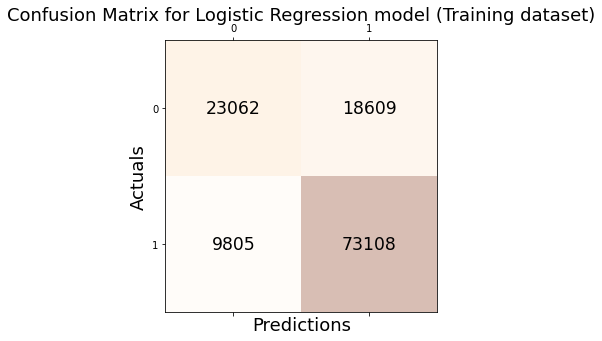

In [53]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true=y_train, y_pred=train_pred_lr)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Logistic Regression model (Training dataset)', fontsize=18)
plt.show()

In [54]:
print("Metrics for Training dataset:\n")
print("precision: "+str(metrics.precision_score(y_train, train_pred_lr)))
print("accuracy: "+str(metrics.accuracy_score(y_train, train_pred_lr)))
print("recall: "+str(metrics.recall_score(y_train, train_pred_lr)))

Metrics for Training dataset:

precision: 0.7971041355473903
accuracy: 0.7719289796442561
recall: 0.8817435142860589


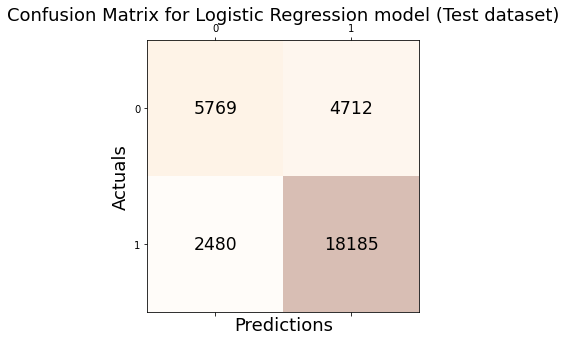

In [55]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=test_pred_lr)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Logistic Regression model (Test dataset)', fontsize=18)
plt.show()

In [56]:
print("Metrics for Test dataset:\n")
print("precision: "+str(metrics.precision_score(y_test, test_pred_lr)))
print("accuracy: "+str(metrics.accuracy_score(y_test, test_pred_lr)))
print("recall: "+str(metrics.recall_score(y_test, test_pred_lr)))

Metrics for Test dataset:

precision: 0.7942088483207407
accuracy: 0.7690875232774674
recall: 0.8799903218001451


##**3.3 SVM's LinearSVC classifier**

In [57]:
from sklearn import svm

In [58]:
# train the Linear SVC model
svmmodel = svm.LinearSVC(random_state=0, tol=1e-5)
svmmodel.fit(x_train_sc,y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=0, tol=1e-05)

In [59]:
train_pred_svm = svmmodel.predict(x_train_sc)
test_pred_svm = svmmodel.predict(x_test_sc)

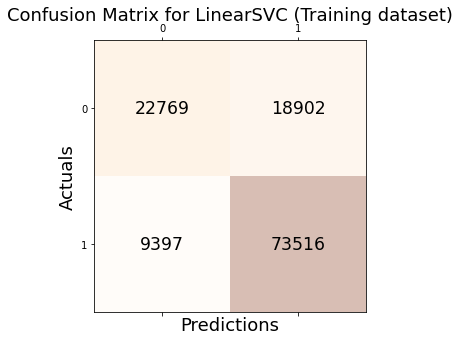

In [60]:
conf_matrix = confusion_matrix(y_true=y_train, y_pred=train_pred_svm)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for LinearSVC (Training dataset)', fontsize=18)
plt.show()

In [61]:
print("Metrics for Training dataset:\n")
print("precision: "+str(metrics.precision_score(y_train, train_pred_svm)))
print("accuracy: "+str(metrics.accuracy_score(y_train, train_pred_svm)))
print("recall: "+str(metrics.recall_score(y_train, train_pred_svm)))

Metrics for Training dataset:

precision: 0.7954727434049644
accuracy: 0.7728520516278173
recall: 0.8866643349052622


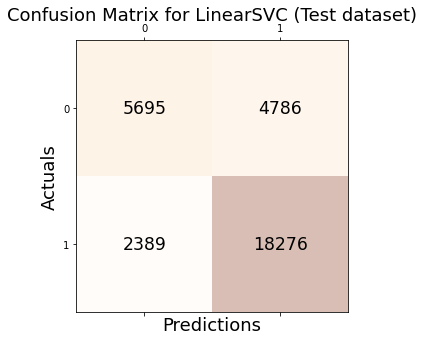

In [62]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=test_pred_svm)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for LinearSVC (Test dataset)', fontsize=18)
plt.show()

In [63]:
print("Metrics for Test dataset:\n")
print("precision: "+str(metrics.precision_score(y_test, test_pred_svm)))
print("accuracy: "+str(metrics.accuracy_score(y_test, test_pred_svm)))
print("recall: "+str(metrics.recall_score(y_test, test_pred_svm)))

Metrics for Test dataset:

precision: 0.7924724655277079
accuracy: 0.7696333397547036
recall: 0.8843939027340915


##**3.4 Random Forest classifier**

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf = RandomForestClassifier(max_depth=28,random_state=42)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=28, random_state=42)

In [66]:
x_train

,overall_rating,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,age
111078,72.0,6,6,44.0,26.0,73.0,61.0,39.0,54.0,31.0,...,21.0,68.0,71.0,31.0,55.0,40.0,70.0,74.0,70.0,25
161955,72.0,6,6,8.0,13.0,11.0,22.0,7.0,11.0,12.0,...,11.0,20.0,21.0,14.0,29.0,22.0,10.0,13.0,16.0,27
159061,72.0,9,9,71.0,63.0,37.0,80.0,68.0,66.0,73.0,...,70.0,28.0,43.0,71.0,78.0,74.0,24.0,31.0,21.0,26
104033,79.0,6,6,57.0,33.0,76.0,74.0,31.0,61.0,46.0,...,35.0,80.0,80.0,40.0,45.0,31.0,80.0,80.0,84.0,21
74601,73.0,6,6,52.0,42.0,61.0,79.0,26.0,56.0,51.0,...,51.0,75.0,69.0,47.0,71.0,42.0,70.0,76.0,71.0,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127076,57.0,9,6,52.0,35.0,45.0,52.0,47.0,60.0,51.0,...,47.0,51.0,56.0,54.0,50.0,38.0,53.0,46.0,55.0,32
109900,78.0,6,9,57.0,59.0,70.0,74.0,56.0,65.0,60.0,...,75.0,82.0,81.0,52.0,78.0,61.0,72.0,83.0,80.0,25
139864,74.0,9,6,82.0,48.0,58.0,76.0,56.0,64.0,85.0,...,79.0,76.0,71.0,65.0,73.0,35.0,71.0,75.0,77.0,28
155675,64.0,6,6,62.0,33.0,59.0,68.0,54.0,60.0,55.0,...,53.0,62.0,64.0,53.0,64.0,54.0,55.0,62.0,61.0,22


In [67]:
train_pred_rf = rf.predict(x_train)
test_pred_rf = rf.predict(x_test)

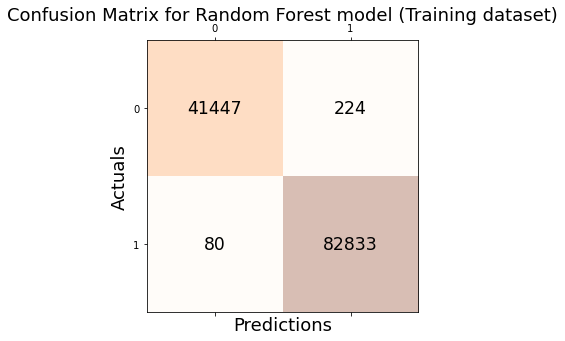

In [68]:
conf_matrix = confusion_matrix(y_true=y_train, y_pred=train_pred_rf)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Random Forest model (Training dataset)', fontsize=18)
plt.show()

In [69]:
print("Metrics for Training dataset:\n")
print("precision: "+str(metrics.precision_score(y_train, train_pred_rf)))
print("accuracy: "+str(metrics.accuracy_score(y_train, train_pred_rf)))
print("recall: "+str(metrics.recall_score(y_train, train_pred_rf)))

Metrics for Training dataset:

precision: 0.9973030569368024
accuracy: 0.997559879278238
recall: 0.999035133211921


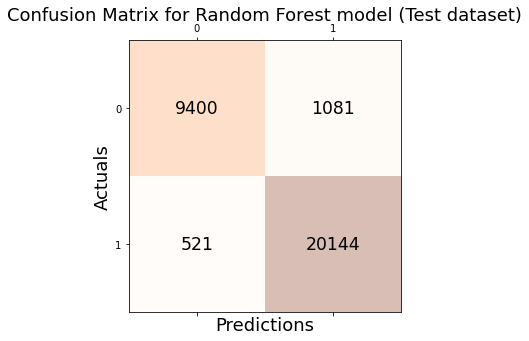

In [70]:
conf_matrix = confusion_matrix(y_true=y_test, y_pred=test_pred_rf)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix for Random Forest model (Test dataset)', fontsize=18)
plt.show()

In [71]:
print("Metrics for Test dataset:\n")
print("precision: "+str(metrics.precision_score(y_test, test_pred_rf)))
print("accuracy: "+str(metrics.accuracy_score(y_test, test_pred_rf)))
print("recall: "+str(metrics.recall_score(y_test, test_pred_rf)))

Metrics for Test dataset:

precision: 0.9490694935217904
accuracy: 0.9485648237333847
recall: 0.9747882893781756


Comparing the models, we can see that Random Forest performs the best and give us an accuracy of 94%. 

Now, We will use our Random Forest model to predict on all player's for the latest season. 

## 3.5 Model Performance Review

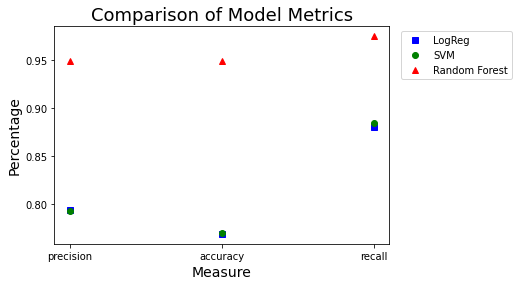

In [79]:
xlr = [1,2,3]
xsvm  = [1,2,3]
xrf  = [1,2,3]


ylr = [(metrics.precision_score(y_test, test_pred_lr)),(metrics.accuracy_score(y_test, test_pred_lr)),(metrics.recall_score(y_test, test_pred_lr))]
ysvm = [(metrics.precision_score(y_test, test_pred_svm)),(metrics.accuracy_score(y_test, test_pred_svm)),(metrics.recall_score(y_test, test_pred_svm))]
yrf = [(metrics.precision_score(y_test, test_pred_rf)),(metrics.accuracy_score(y_test, test_pred_rf)),(metrics.recall_score(y_test, test_pred_rf))]

xticks=['precision','accuracy','recall']



plt.plot(xlr,ylr,'bo', label = 'LogReg', marker = 's')
plt.plot(xsvm,ysvm,'go', label = 'SVM', marker = 'o')
plt.plot(xrf,yrf,'ro', label = 'Random Forest', marker = '^')
plt.xticks(xlr,xticks )
plt.title("Comparison of Model Metrics",fontsize=18)
plt.xlabel('Measure', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.legend(bbox_to_anchor=(1.02, 1),loc = 'upper left')
plt.show()

# **4. Predictions on Final dataset**

Now that we are done fine-tuning our model, it is ready to be used on our main and final dataset.
To recall, our dataset had values from 2007-2016. We have trained our dataset to predict on player's future performance. This section will predict on all the player's (mentioned in the dataset) future performance in the next period/season of data. 

Previously we had separated out a final_players_df which had `peak_flg_2` column 'None'. Now we will fill this solumn based on our model.

In [73]:
# final_player_df
final_player_test_df = final_player_df.drop(columns=['id', 'player_fifa_api_id', 'player_api_id', 'date', 'potential', 'player_name', 'date', 'birthday', 'height', 'weight', 'peak_flg', 'peak_flg_2'])
final_player_test_df

,overall_rating,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,...,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,age
0,74.0,9,6,80.0,53.0,58.0,71.0,40.0,73.0,70.0,...,62.0,68.0,67.0,60.0,66.0,59.0,76.0,75.0,78.0,27
32,65.0,6,6,64.0,58.0,60.0,66.0,52.0,66.0,67.0,...,57.0,60.0,55.0,64.0,68.0,61.0,23.0,22.0,24.0,25
57,69.0,6,6,57.0,21.0,68.0,65.0,48.0,56.0,38.0,...,29.0,70.0,62.0,26.0,54.0,37.0,72.0,71.0,68.0,34
79,70.0,6,6,46.0,34.0,73.0,65.0,33.0,47.0,42.0,...,26.0,66.0,68.0,29.0,41.0,45.0,75.0,73.0,71.0,36
103,77.0,6,6,77.0,72.0,64.0,79.0,77.0,78.0,77.0,...,76.0,59.0,55.0,77.0,76.0,81.0,28.0,34.0,35.0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165028,64.0,6,6,65.0,60.0,42.0,68.0,34.0,75.0,53.0,...,78.0,75.0,26.0,54.0,35.0,76.0,39.0,26.0,24.0,28
165035,75.0,6,6,57.0,40.0,73.0,66.0,39.0,56.0,36.0,...,56.0,79.0,81.0,44.0,47.0,48.0,78.0,79.0,71.0,27
165055,73.0,3,6,42.0,27.0,74.0,70.0,30.0,54.0,49.0,...,30.0,75.0,66.0,22.0,52.0,50.0,76.0,77.0,72.0,36
165067,63.0,9,6,65.0,44.0,59.0,63.0,49.0,57.0,67.0,...,31.0,67.0,61.0,49.0,49.0,53.0,57.0,61.0,61.0,28


In [74]:
rf.predict(final_player_test_df)

array([1, 0, 0, ..., 0, 0, 0])

Let's convert the predictions into categorical values for better undertsanding. Like previously done, we change 1 to `RISE` and 0 to `DECLINE`.

In [82]:
final_player_df.loc[:, ('predictions')] = rf.predict(final_player_test_df)
final_player_df.loc[:, ('peak_flg_2')] = final_player_df['predictions'].apply(lambda x: 'RISE' if x == 1 else 'DECLINE')
final_player_df

,id,player_fifa_api_id,player_name,age,date,peak_flg,peak_flg_2,overall_rating,potential,attacking_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,player_api_id,birthday,height,weight,predictions
0,6,189615,Aaron Cresswell,27,2016-04-21 00:00:00,RISE,RISE,74.0,76.0,9,...,66.0,59.0,76.0,75.0,78.0,155782,1989-12-15 00:00:00,170.18,146,1
32,39,186170,Aaron Doran,25,2016-01-07 00:00:00,DECLINE,DECLINE,65.0,67.0,6,...,68.0,61.0,23.0,22.0,24.0,162549,1991-05-13 00:00:00,170.18,163,0
57,65,140161,Aaron Galindo,34,2016-04-21 00:00:00,DECLINE,DECLINE,69.0,69.0,6,...,54.0,37.0,72.0,71.0,68.0,30572,1982-05-08 00:00:00,182.88,198,0
79,88,17725,Aaron Hughes,36,2015-12-24 00:00:00,DECLINE,DECLINE,70.0,70.0,6,...,41.0,45.0,75.0,73.0,71.0,23780,1979-11-08 00:00:00,182.88,154,0
103,113,158138,Aaron Hunt,30,2016-04-28 00:00:00,DECLINE,DECLINE,77.0,77.0,6,...,76.0,81.0,28.0,34.0,35.0,27316,1986-09-04 00:00:00,182.88,161,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165028,183896,195840,Zouhaier Dhaouadhi,28,2016-01-21 00:00:00,RISE,RISE,64.0,64.0,6,...,35.0,76.0,39.0,26.0,24.0,192132,1988-01-01 00:00:00,180.34,159,1
165035,183904,205705,Zouhair Feddal,27,2016-02-04 00:00:00,RISE,RISE,75.0,76.0,6,...,47.0,48.0,78.0,79.0,71.0,282473,1989-01-01 00:00:00,190.50,172,1
165055,183925,2488,Zoumana Camara,36,2015-03-06 00:00:00,DECLINE,DECLINE,73.0,73.0,3,...,52.0,50.0,76.0,77.0,72.0,26357,1979-04-03 00:00:00,182.88,168,0
165067,183938,164680,Zsolt Laczko,28,2014-09-18 00:00:00,DECLINE,DECLINE,63.0,67.0,9,...,49.0,53.0,57.0,61.0,61.0,111182,1986-12-18 00:00:00,182.88,176,0


Re-ordering column names so it's clearer to understand

In [76]:
final_player_df = final_player_df[['id', 'player_fifa_api_id', 'player_name', 'age', 'date', 'peak_flg', 'peak_flg_2', 'overall_rating', 'potential',
       'attacking_work_rate', 'defensive_work_rate', 'crossing', 'finishing',
       'heading_accuracy', 'short_passing', 'volleys', 'dribbling', 'curve',
       'free_kick_accuracy', 'long_passing', 'ball_control', 'acceleration',
       'sprint_speed', 'agility', 'reactions', 'balance', 'shot_power',
       'jumping', 'stamina', 'strength', 'long_shots', 'aggression',
       'interceptions', 'positioning', 'vision', 'penalties', 'marking',
       'standing_tackle', 'sliding_tackle', 'player_api_id', 
       'birthday', 'height', 'weight', 'predictions']]

We will now see predictions for players that we had earlier picked out in section 2.4.

`peak_flg` and `peak_flg_2` respectively represent a player's last recorded performance and predicted future performance (in the next period). 

For example, **Eden Hazard** was on the declining curve (see plot on section 2.4) but as of January 2016, has started to rise back. This makes a lot of sense since his Potential Rating (given by FIFA) is greater than his current Rating.

Another notable case is **Virgil Van Dijk**, whose Potential Rating is greater than his current Rating, and whose skills started to raise (see plot in section 2.4). We can see that our model predicts that he will continue in the RISE stage over the next period.

Finally, there are some cases such as **Santi Cazorla** and **Sergio Garcia**. They are currently in their RISE stage (as we can see in section 2.4), but our model predicts that their curve will change their slopes to DECLINE. 

*Thus, a scout studying the acquision of those players at that time should be cautious about the signing!*

In [77]:
final_player_df[final_player_df['player_name'].isin(['Lionel Messi', 'Santi Cazorla', 'Sergio Garcia','Gerard Pique', 'Cristiano Ronaldo', 'Edinson Cavani', 'Eden Hazard', 'Virgil van Dijk', 'Andres Iniesta'])]

,id,player_fifa_api_id,player_name,age,date,peak_flg,peak_flg_2,overall_rating,potential,attacking_work_rate,...,vision,penalties,marking,standing_tackle,sliding_tackle,player_api_id,birthday,height,weight,predictions
11425,12774,41,Andres Iniesta,31,2015-10-16 00:00:00,DECLINE,DECLINE,88.0,88.0,9,...,92.0,71.0,57.0,57.0,56.0,30955,1984-05-11 00:00:00,170.18,150,0
29861,33331,20801,Cristiano Ronaldo,30,2015-10-16 00:00:00,RISE,RISE,93.0,93.0,9,...,81.0,85.0,22.0,31.0,23.0,30893,1985-02-05 00:00:00,185.42,176,1
42322,47248,183277,Eden Hazard,25,2016-01-28 00:00:00,DECLINE,RISE,88.0,90.0,9,...,86.0,86.0,25.0,27.0,22.0,107417,1991-01-07 00:00:00,172.72,163,1
42761,47726,179813,Edinson Cavani,29,2016-03-17 00:00:00,DECLINE,DECLINE,85.0,85.0,9,...,77.0,82.0,24.0,45.0,27.0,49677,1987-02-14 00:00:00,182.88,157,0
56519,62978,152729,Gerard Pique,28,2015-10-16 00:00:00,DECLINE,DECLINE,85.0,85.0,9,...,62.0,69.0,86.0,87.0,83.0,37482,1987-02-02 00:00:00,193.04,187,0
92008,102483,158023,Lionel Messi,28,2015-12-17 00:00:00,RISE,RISE,94.0,94.0,6,...,90.0,74.0,13.0,23.0,21.0,30981,1987-06-24 00:00:00,170.18,159,1
141600,157740,146562,Santi Cazorla,32,2016-01-28 00:00:00,RISE,DECLINE,85.0,85.0,6,...,85.0,80.0,56.0,62.0,48.0,37436,1984-12-13 00:00:00,167.64,146,0
144682,161136,135697,Sergio Garcia,32,2015-02-13 00:00:00,RISE,DECLINE,79.0,79.0,6,...,76.0,77.0,25.0,29.0,27.0,38578,1983-06-09 00:00:00,175.26,159,0
159684,177844,203376,Virgil van Dijk,25,2016-03-17 00:00:00,RISE,RISE,77.0,83.0,9,...,59.0,64.0,77.0,81.0,74.0,209405,1991-07-08 00:00:00,193.04,203,1
